In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt, mpld3
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
np.random.seed(12345)

In [6]:
# Download the latest SO dataset here: https://drive.google.com/open?id=1QOmVDpd8hcVYqqUXDXf68UMDWQZP0wQV
data_2019 = pd.read_csv("developer_survey_2019/survey_results_public.csv", low_memory=False)

In [7]:
to_drop = ["Respondent", "OpenSource", "CareerSat", "JobSat", "JobSeek", "ResumeUpdate", "SurveyLength", "SurveyEase",
    "WelcomeChange", "EntTeams", "ScreenName", "LastIn", "SO", "Blockchain", "WorkChallenge", "BetterLife", "OffOn", "Currency",
    "CompTotal", "CompFreq", "MainBranch", "PlatformDesireNextYear", "LanguageDesireNextYear", "DatabaseDesireNextYear", 
    "MiscTechDesireNextYear", "WebFrameDesireNextYear", "MgrMoney", "ITperson", "Age1stCode"]

In [8]:
def col_drop(df, to_drop):

    df_dropped = df.copy()

    for flag in to_drop:
        try:
            df_dropped.drop([x for x in df_dropped.columns if flag in x], axis=1, inplace=True)
        except:
            pass

    return df_dropped

In [9]:
def string_replace(s):
    try:
        s = float(s)
    except:
        s = -1000

    return s

In [10]:
def text_clean(text):
    text = str(text).replace(" ", "_").replace("-", "_").replace(
        ",", "_").replace(".", "").replace("+", "p").replace("#", "s").replace(
            "/", "_").replace("'", "").replace("ʼ", "").replace(
                "(", "_").replace(")", "_").replace("’", "").replace(
                    "__", "_").replace("__", "_").replace("“", "").replace(
                        "”", "").replace(":", "_").replace("&", "_").lower()

    return text

In [11]:
def create_controls(df, exclude):

    controls = {}

    for col in df.columns:
        if col != exclude:
            controls[col] = {
                "omitted": text_clean(pd.Series([x for sub in list(
                    data_2019[col]
                    .apply(text_clean)
                    .apply(lambda x: str(x).split(";"))) for x in sub])
                    .value_counts()
                    .idxmax()), 
                "controls": list(set([x for sub in list(
                    data_2019[col]
                    .apply(text_clean)
                    .apply(lambda x: str(x).split(";"))) for x in sub]))}
    
    return controls

In [12]:
def design_matrix(df, controls):
    dm = df.copy()
    
    for control in controls.keys():
        dm[control] = dm[control].apply(text_clean)

        if control in num_columns:
            for c in controls[control]["controls"]:
                dm[control+"_"+c] = (dm[control] == c) * 1

        else:
            for c in controls[control]["controls"]:
                dm[control+"_"+c] = dm[control].apply(lambda x: c in str(x).split(";")) * 1

        dm.drop(control, axis=1, inplace=True)
        dm.drop(control+"_"+controls[control]["omitted"], axis=1, inplace=True)
    
    return dm

In [13]:
data_2019 = col_drop(data_2019, to_drop)
print("Success!")
print(data_2019.head().T.shape)

Success!
(43, 5)


In [14]:
# Only consider those with income between $10,000 and $250,000
data_2019 = data_2019[(data_2019["ConvertedComp"] >= 10000) & (data_2019["ConvertedComp"] <= 250000)]
data_2019["ConvertedComp"] = np.log(data_2019["ConvertedComp"])
data_2019 = data_2019.rename(columns = {"ConvertedComp": "Income"})

# Only consider US respondents
data_2019 = data_2019[data_2019["Country"] == "United States"]
data_2019.drop(["Country"], axis=1, inplace=True)

# Only consider 18+ respondents
data_2019 = data_2019[data_2019["Age"] >= 18]

# Only consider respondents in the workforce
data_2019 = data_2019[data_2019["Employment"] != "Retired"]
data_2019 = data_2019[data_2019["Employment"] != "Not employed, and not looking for work"]

data_2019 = data_2019[data_2019["WorkWeekHrs"] >= 5]

# Only consider those with at least some education
data_2019 = data_2019[data_2019["EdLevel"] != "I never completed any formal education"]

data_2019 = data_2019.fillna("no_answer")

num_columns = ["Age", "YearsCode", "YearsCodePro", "WorkWeekHrs", "CodeRevHrs"]

# Convert numeric columns to int
for col in num_columns:
    data_2019[col] = data_2019[col].astype("int32", errors="ignore")

#data_2019["Age1stCode"].replace("Younger than 5 years", "4", inplace=True)
data_2019["YearsCode"].replace("Less than 1 year", "0", inplace=True)
data_2019["YearsCode"].replace("More than 50 years", "51", inplace=True)

for col in num_columns:
    data_2019[col] = data_2019[col].apply(string_replace)

# Exclude respondents who selected multiple gender, race, or sexual orientation
# options
data_2019 = data_2019[~data_2019["Gender"].str.contains(";")]
data_2019 = data_2019[~data_2019["Ethnicity"].str.contains(";")]
data_2019 = data_2019[~data_2019["Sexuality"].str.contains(";")]

# Reset index
data_2019 = data_2019.reset_index(drop=True)

In [15]:
# TODO: Refactor this

num_labels = [
    ["no_answer","-20", "21-25", "26-30", "31-35", "35-40", "41-45", "45-50", "51-55", "55-60", "61-65", "66-"],
    #["no_answer","-20", "21-25", "26-30", "31-35", "35-40", "41-45", "45-50", "51-55", "55-60", "61-65", "66-"],
    ["no_answer","0-5", "6-10", "11-15", "16-20", "21-25", "26-30", "31-35", "35-40", "41-"],
    ["no_answer","0-5", "6-10", "11-15", "16-20", "21-25", "26-30", "31-35", "35-40", "41-"],
    ["no_answer","-10", "11-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-"],
    ["no_answer","1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11-15", "16-20", "21-"]]

num_buckets = [
    np.array([-1001,0,20,25,30,35,40,45,50,55,60,65,100]),
    #np.array([-1001,0,20,25,30,35,40,45,50,55,60,65,100]),
    np.array([-1001,0,5,10,15,20,25,30,35,40,100]),
    np.array([-1001,0,5,10,15,20,25,30,35,40,100]),
    np.array([-1001,0,10,20,30,40,50,60,70,80,200]),
    np.array([-1001,0,1,2,3,4,5,6,7,8,9,10,15,20,200])
]

#age_labels = ["no_answer","-20", "21-25", "26-30", "31-35", "35-40", "41-45", "45-50", "51-55", "55-60", "61-65", "66-"]
#year_labels = ["no_answer","0-5", "6-10", "11-15", "16-20", "21-25", "26-30", "31-35", "35-40", "41-"]
#work_week_hour_labels = ["no_answer","-10", "11-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-"]
#code_rev_hour_labels = ["no_answer","1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11-15", "16-20", "21-"]

#age_buckets = np.array([-1001,0,20,25,30,35,40,45,50,55,60,65,100])
#year_buckets = np.array([-1001,0,5,10,15,20,25,30,35,40,100])
#work_week_hour_buckets = np.array([-1001,0,10,20,30,40,50,60,70,80,200])
#code_rev_hour_buckets = np.array([-1001,0,1,2,3,4,5,6,7,8,9,10,15,20,200])

In [16]:
# TODO: Refactor this

for i, col in enumerate(num_columns):
    data_2019[col] = pd.cut(data_2019[col], num_buckets[i], labels=num_labels[i]).astype("str")

#data_2019["Age"] = pd.cut(data_2019["Age"], age_buckets, labels=age_labels).astype("str")
#data_2019["Age1stCode"] = pd.cut(data_2019["Age1stCode"], age_buckets, labels=age_labels).astype("str")
#data_2019["YearsCode"] = pd.cut(data_2019["YearsCode"], year_buckets, labels=year_labels).astype("str")
#data_2019["YearsCodePro"] = pd.cut(data_2019["YearsCodePro"], year_buckets, labels=year_labels).astype("str")
#data_2019["WorkWeekHrs"] = pd.cut(data_2019["WorkWeekHrs"], work_week_hour_buckets, labels=work_week_hour_labels).astype("str")
#data_2019["CodeRevHrs"] = pd.cut(data_2019["CodeRevHrs"], code_rev_hour_buckets, labels=code_rev_hour_labels).astype("str")

In [17]:
controls = create_controls(data_2019, "Income")

In [18]:
data_2019 = design_matrix(data_2019, controls)

In [19]:
if False:

    test = "PlatformWorkedWith"

    for c in controls[test]["controls"]:
        if c != controls[test]["omitted"]:
            X, Y = data_2019.drop("Income", axis=1).astype(float).copy(), data_2019["Income"].values

            t = test + "_" + c

            T = X[t]
            X = X.drop(t, axis=1)
            clf = LassoCV(cv=5, max_iter=10000, selection="random", n_jobs=-1)

            sfm = SelectFromModel(clf)

            H, K = sfm.fit(X.drop([x for x in X.columns if test in x], axis=1), Y).get_support(), sfm.fit(X.drop([x for x in X.columns if test in x], axis=1), T).get_support()

            U = H | K

            X_U = X[np.unique(np.append(X.drop([x for x in X.columns if test in x], axis=1).columns[U], [x for x in X.columns if test in x]))].copy()
    
            X_U.loc[:, t] = T.copy()

            X_U = sm.add_constant(X_U)
            est = sm.OLS(endog=Y, exog=X_U).fit()
            print(t, est.params[-1], est.bse[-1]*1.96)

In [20]:
est = sm.OLS(endog=data_2019["Income"].values, exog=sm.add_constant(data_2019.drop("Income", axis=1))).fit()

ion. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/fro

In [21]:
est.summary()

0.0170      0.013      1.353      0.176      -0.008       0.042
WebFrameWorkedWith_reactjs                                                                                              0.0404      0.008      4.850      0.000       0.024       0.057
WebFrameWorkedWith_django                                                                                              -0.0343      0.012     -2.824      0.005      -0.058      -0.010
WebFrameWorkedWith_ruby_on_rails                                                                                       -0.0198      0.016     -1.202      0.230      -0.052       0.012
WebFrameWorkedWith_angular_angularjs                                                                                   -0.0102      0.009     -1.196      0.232      -0.027       0.007
WebFrameWorkedWith_express                                                                                             -0.0011      0.010     -0.114      0.910      -0.021       0.018
WebFrameWorkedWith_drupal                                                                                              -0.0563      0.021     -2.667      0.008      -0.098      -0.015
WebFrameWorkedWith_other_s__                                                                                            0.0173      0.013      1.334      0.182      -0.008       0.043
WebFrameWorkedWith_flask                                                                                                0.0079      0.012      0.660      0.509      -0.015       0.031
WebFrameWorkedWith_vuejs                                                                                               -0.0204      0.010     -1.964      0.050      -0.041   -4.26e-05
WebFrameWorkedWith_laravel                                                                                             -0.0117      0.017     -0.670      0.503      -0.046       0.022
WebFrameWorkedWith_spring                                                                                              -0.0173      0.012     -1.383      0.167      -0.042       0.007
MiscTechWorkedWith_apache_spark                                                                                        -0.0077      0.019     -0.412      0.681      -0.045       0.029
MiscTechWorkedWith_react_native                                                                                        -0.0090      0.014     -0.658      0.511      -0.036       0.018
MiscTechWorkedWith_unity_3d                                                                                            -0.0199      0.015     -1.317      0.188      -0.049       0.010
MiscTechWorkedWith_cryengine                                                                                           -0.1302      0.104     -1.249      0.212      -0.334       0.074
MiscTechWorkedWith_cordova                                                                                             -0.0319      0.019     -1.637      0.102      -0.070       0.006
MiscTechWorkedWith_xamarin                                                                                             -0.0458      0.017     -2.668      0.008      -0.079      -0.012
MiscTechWorkedWith_puppet                                                                                               0.0136      0.020      0.667      0.505      -0.026       0.053
MiscTechWorkedWith_chef                                                                                                 0.0282      0.018      1.578      0.115      -0.007       0.063
MiscTechWorkedWith_no_answer                                                                                            0.0062      0.009      0.676      0.499      -0.012       0.024
MiscTechWorkedWith_net_core                                                                                             0.0225      0.011      2.062      0.039       0.001       0.044
MiscTechWorkedWith_net                                                  

In [22]:
def output_graph(df, controls, category, category_plain):
   """
   Plots the income regression coefficients for given category

   df: DataFrame with all variables
   controls: List of controls for full regression
   category: Relevant category for chart
   category_plain: Plaintext for insertion in subtitle

   Returns: DataFrame of plotted data
   """

   controls_adj = [category+"_"+control for control in controls[category]["controls"] if controls[category]["omitted"] != control]
 
   est_full = sm.OLS(endog=df["Income"], exog=df.drop("Income", axis=1).assign(const=1)).fit()
   est_simple = sm.OLS(endog=df["Income"], exog=df.drop("Income", axis=1)[controls_adj].assign(const=1)).fit()
 
   output_full = pd.concat([est_full.params, est_full.bse*1.96], axis=1).rename(columns={0: "coef_full", 1: "conf_95_full"}).filter(like=category+"_", axis=0)

   output_simple = pd.concat([est_simple.params, est_simple.bse*1.96], axis=1).rename(columns={0: "coef_simple", 1: "conf_95_simple"}).filter(like=category+"_", axis=0)
 
   output = pd.concat([output_full, output_simple], axis=1)
 
   output.index = [control for control in controls[category]["controls"] if controls[category]["omitted"] != control]

   output.sort_values(by="coef_full", ascending=False, inplace=True)

   output["explained"] = output["coef_simple"] - output["coef_full"]

   my_range=np.array(list(range(1,len(controls_adj)+1)))

   fig, ax = plt.subplots(figsize=(len(controls_adj), 5), dpi = 200)
   #plt.ylim(-.6,.4) # Needed for certain charts?
 
   plt.vlines(x=my_range-0.1, ymin=0, ymax=output["coef_simple"], color='#007acc', alpha=0.2, linewidth=10)
   plt.plot(my_range-0.1, output["coef_simple"], "o", markersize=10, color='#3493d3', alpha=1)
   plt.errorbar(x = my_range-0.1, y = output["coef_simple"], yerr = output["conf_95_simple"], fmt = "none", color='#3493d3', alpha = 1, capsize=3)
   
   plt.vlines(x=my_range+0.1, ymin=0, ymax=output["coef_full"], color='red', alpha=0.2, linewidth=10)
   plt.plot(my_range+0.1, output["coef_full"], "o", markersize=10, color='#ff4747', alpha=1)
   plt.errorbar(x = my_range+0.1, y = output["coef_full"], yerr = output["conf_95_full"], fmt = "none", color='#ff4747', alpha = 1, capsize=3)

   plt.axhline(xmin = 0.01, xmax = 1 - len(my_range)/1000, y = 0, color = "grey", linestyle = "-")
   
   ax.set_yticklabels(['{:,.1%}'.format(y) for y in ax.get_yticks()])

   output_index = [x[:16] for x in output.index]

   for i in range(0, len(output_index), 2):
       output_index[i] = "\n" + output_index[i]

   plt.xticks(my_range, output_index)

   plt.legend(["no controls", "w/ controls"], loc='lower right')

   plt.suptitle("% Income impact of " + category_plain + " compared to " + controls[category]["omitted"], x = 0.12, y = .94, horizontalalignment = "left", fontsize = 12, fontstyle="oblique", color = 'grey')

   #mpld3.fig_to_html(fig)
 
   return mpld3.fig_to_html(fig)

In [23]:
def prune_df(df, category):
    """
    Prunes dataframe columns to only include those with "category_" in the name
    
    Returns: Pruned dataframe
    """

    matching = [x for x in df.columns if category+"_" in x]

    return df[matching].copy()

In [24]:
def explain(df, regression, controls, cat_to_explain, coef_to_explain, top=3):
    """
    Decomposes explained portion of income gap between groups and returns top explainers

    Decomposition follows methodology of (Gelbach 2016)

    Returns: Dataframe with top 3 explainers and respective explained gaps
    """

    name = cat_to_explain + "_" + coef_to_explain

    df_copy = df.copy()

    X_1 = prune_df(df_copy, cat_to_explain).assign(const=1)

    explainers = [control for control in controls.keys() if control != cat_to_explain]

    results = pd.DataFrame()
    
    for i, explainer in enumerate(explainers):

        X_2 = prune_df(df_copy, explainer)

        X_2 = X_2.reindex(sorted(X_2.columns), axis=1)

        B_2 = regression.params.filter(like=explainer+"_").sort_index()

        H_k = X_2.values @ B_2

        if i == 0:
            results = pd.DataFrame(sm.OLS(endog=H_k, exog=X_1).fit().params.rename(explainer))
        else:
            d = sm.OLS(endog=H_k, exog=X_1).fit().params.rename(explainer)

            results = results.join(d)

    neg = results.T.filter(like=name).sort_values(by=name)[name].sum() < 0

    results = results.T.filter(like=name).sort_values(by=name, ascending=neg)

    results.columns = ["Explained"]

    return results.iloc[:top].append(results.iloc[top:].sum().rename("Other")), regression.params.filter(like=name).values[0]

In [29]:
def output_waterfall(df, coef_full):
   """
   Plots...


   """

   #coef_full = regression.params.filter()
   coef_simple = 0

   step_names = ["w/ Controls"] + list(df.index) + ["No Controls"]
   
   step_cum = [0]
   steps = np.array([coef_full] + list(df.values.flatten()) + [coef_simple])

   for i in range(len(step_names)):
       if i != 0:
           step_cum.append(sum(steps[:i]))
   
   step_min = np.array(step_cum)
   step_max = step_min + steps

   my_range=np.array(list(range(1,len(steps)+1)))

   fig, ax = plt.subplots(figsize=(len(steps), 5), dpi = 200)
   #plt.ylim(-.6,.4) # Needed for certain charts?

   plt.vlines(x=1, ymin=step_min[0], ymax=step_max[0], color='#ff4747', alpha=1, linewidth=30)
 
   plt.vlines(x=my_range[1:-1], ymin=step_min[1:-1], ymax=step_max[1:-1], color='green', alpha=0.3, linewidth=30)

   plt.vlines(x=my_range[-1], ymin=0, ymax=step_max[-1], color='#3493d3', alpha=1, linewidth=30)

   plt.axhline(xmin = 0.01, xmax = 1 - len(my_range)/1000, y = 0, color = "grey", linestyle = "-")
   
   ax.set_yticklabels(['{:,.1%}'.format(y) for y in ax.get_yticks()])

   for i in range(0, len(step_names), 2):
       step_names[i] = "\n" + step_names[i]

   plt.xticks(my_range, step_names)

   #plt.legend(["no controls", "w/ controls"], loc='lower right')

   #plt.suptitle("% Income impact of " + category_plain + " compared to " + controls[category]["omitted"], x = 0.12, y = .94, horizontalalignment = "left", fontsize = 12, fontstyle="oblique", color = 'grey')"""
 
   #return step_names, steps, step_min, step_max

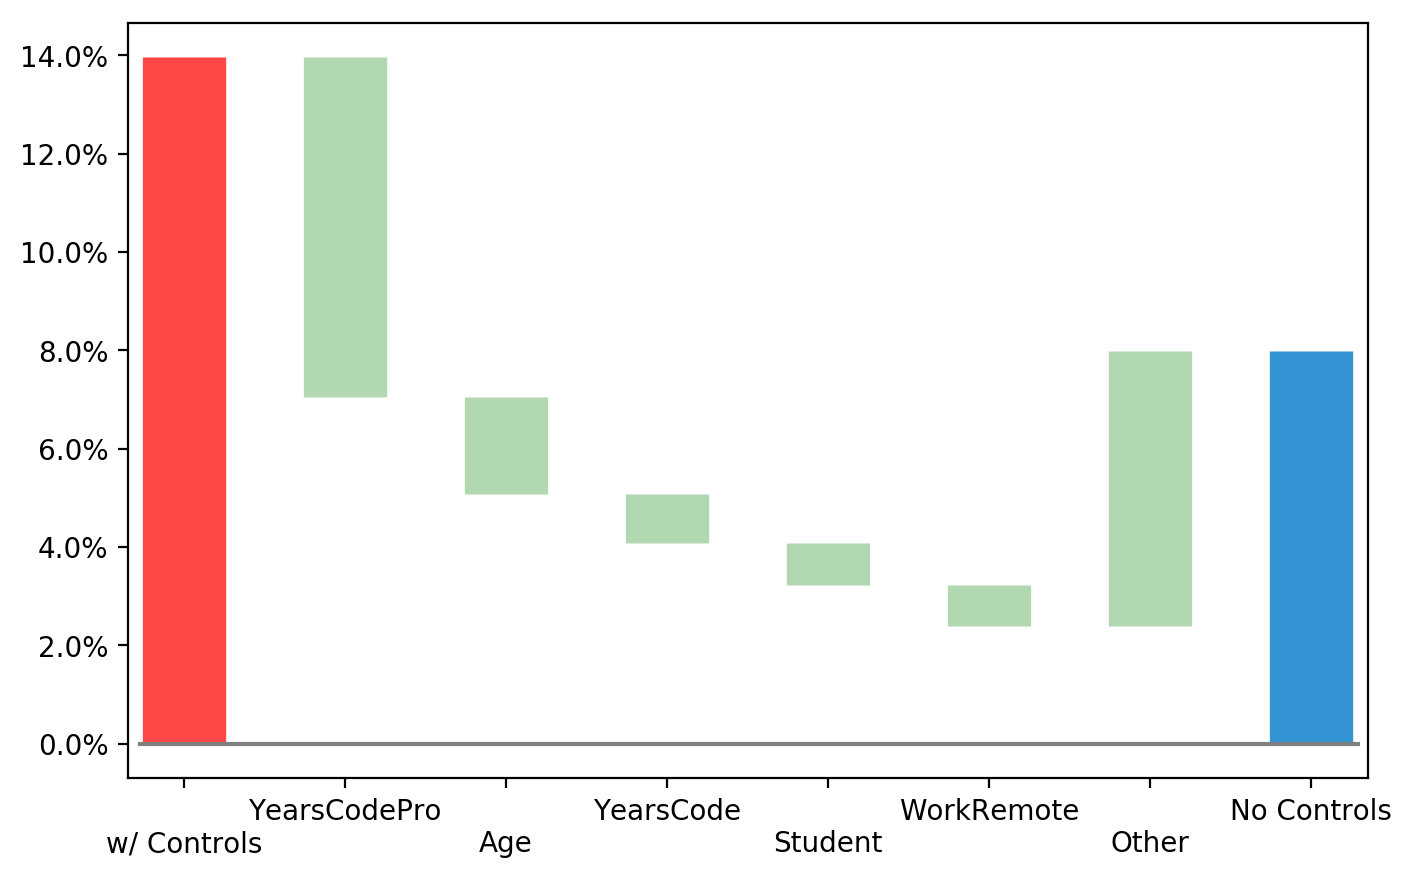

In [30]:
output, coef_full = explain(data_2019, est, controls, "Ethnicity", "east_asian", 5)

output_waterfall(output, coef_full)

In [183]:
explain(data_2019, est, controls, "Ethnicity", "black_or_of_african_descent")

,1
0,
YearsCodePro,-0.0555733
ImpSyn,-0.0104746
YearsCode,-0.010334
Age,-0.0103185
WorkWeekHrs,-0.00420831
CodeRev,-0.00414998
PurchaseWhat,-0.00381442
Gender,-0.00304313
DatabaseWorkedWith,-0.00228621


In [26]:
test = output_graph(data_2019, controls, "Ethnicity", "white")

/anaconda3/lib/python3.7/site-packages/mpld3/mplexporter/exporter.py:84: UserWarning: Blended transforms not yet supported. Zoom behavior may not work as expected.
  warnings.warn("Blended transforms not yet supported. "


TypeError: Object of type ndarray is not JSON serializable

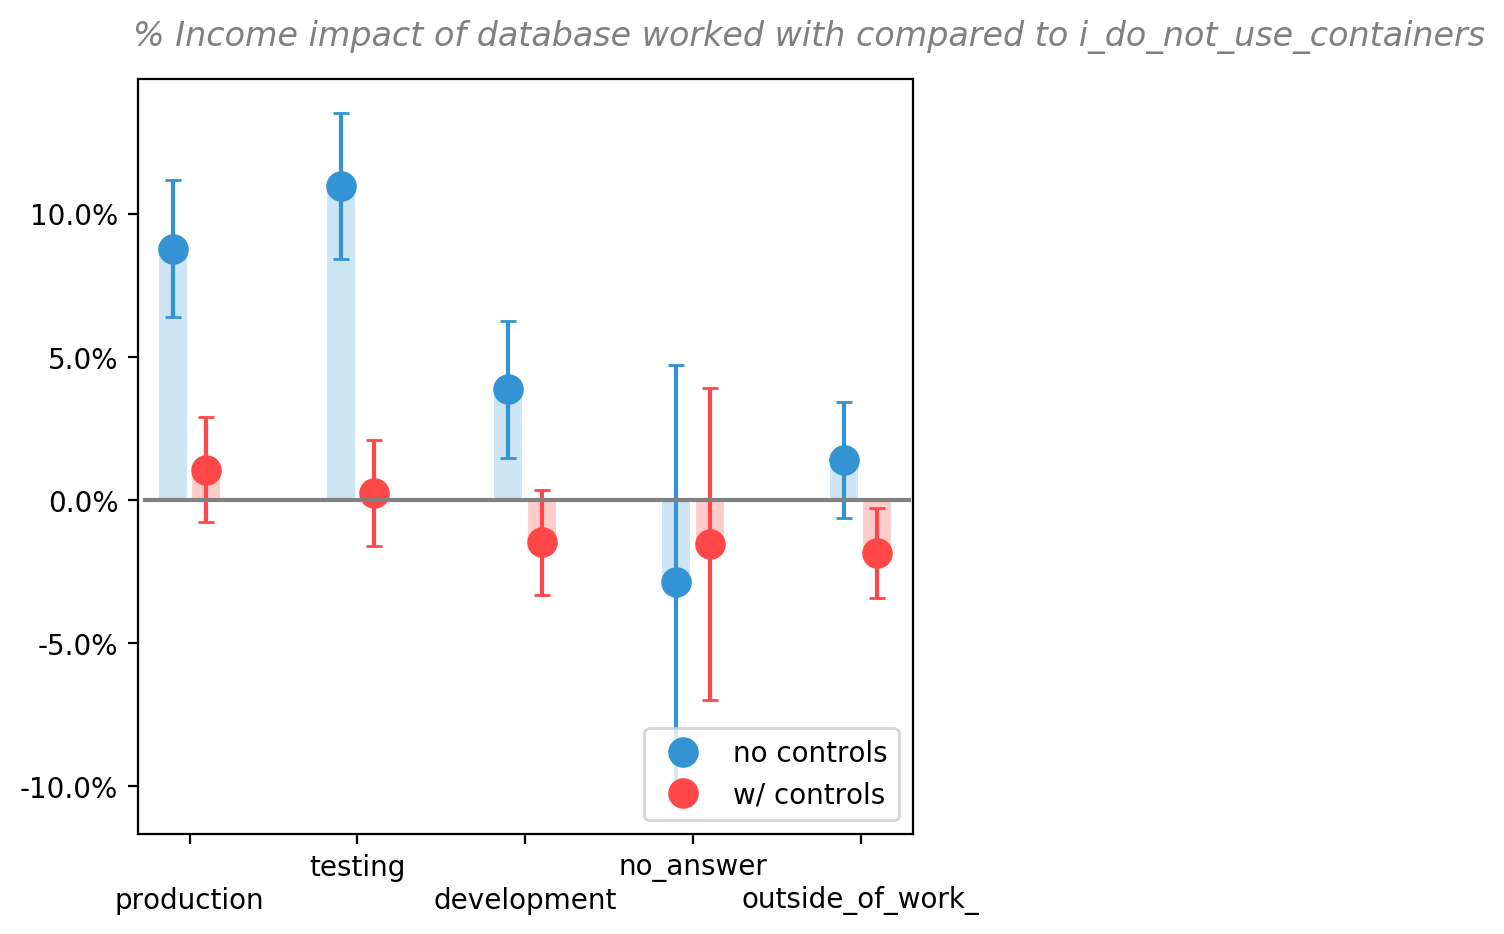

In [617]:
test = output_graph(data_2019, controls, "Containers", "database worked with")

In [615]:
test

,coef_full,conf_95_full,coef_simple,conf_95_simple,explained
yes_its_not_part_of_our_process_but_the_developers_do_it_on_their_own,-0.049284,0.016814,-0.114035,0.022611,-0.064751
no_but_i_think_we_should,-0.093752,0.016691,-0.302983,0.020000,-0.209231
no_and_im_glad_we_dont,-0.103342,0.032264,-0.322163,0.042245,-0.218821
no_answer,-0.148982,0.071382,-0.219170,0.037773,-0.070188
